In [54]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Load dataset                                                            

In [55]:
df=pd.read_csv('ipl.csv')

In [56]:
df.head()


,match_id,season,date,city,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,player_of_match,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,runs_scored,extras,current_score,wickets_down,balls_remaining,wickets_remaining,current_run_rate,required_run_rate,target_score,wicket_kind,player_out,fielder
0,335982,2007/08,4/18/2008,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,0,119,10,6.0,NaN,NaN,NaN,NaN,NaN
1,335982,2007/08,4/18/2008,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,1,0,118,10,3.0,NaN,NaN,NaN,NaN,NaN
2,335982,2007/08,4/18/2008,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,2,0,118,10,6.0,NaN,NaN,NaN,NaN,NaN
3,335982,2007/08,4/18/2008,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,117,10,4.0,NaN,NaN,NaN,NaN,NaN
4,335982,2007/08,4/18/2008,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,116,10,3.0,NaN,NaN,NaN,NaN,NaN


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   match_id           278205 non-null  int64  
 1   season             278205 non-null  object 
 2   date               278205 non-null  object 
 3   city               265808 non-null  object 
 4   venue              278205 non-null  object 
 5   team1              278205 non-null  object 
 6   team2              278205 non-null  object 
 7   toss_winner        278205 non-null  object 
 8   toss_decision      278205 non-null  object 
 9   winner             273503 non-null  object 
 10  result             278205 non-null  object 
 11  result_margin      278205 non-null  object 
 12  player_of_match    277399 non-null  object 
 13  inning             278205 non-null  int64  
 14  batting_team       278205 non-null  object 
 15  bowling_team       278205 non-null  object 
 16  ov

In [58]:
df['over']

0          0
1          0
2          0
3          0
4          0
          ..
278200    18
278201    19
278202    19
278203    19
278204    19
Name: over, Length: 278205, dtype: int64

In [59]:
import pandas as pd

# Define the mapping for merging team names
team_rename_dict = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Deccan Chargers': 'Sunrisers Hyderabad'
}

# Apply merging to both team columns
df['batting_team'] = df['batting_team'].replace(team_rename_dict)
df['bowling_team'] = df['bowling_team'].replace(team_rename_dict)

# List of 10 active teams for IPL 2025
active_teams = [
    'Chennai Super Kings', 'Delhi Capitals', 'Kolkata Knight Riders', 
    'Mumbai Indians', 'Punjab Kings', 'Rajasthan Royals', 
    'Royal Challengers Bengaluru', 'Sunrisers Hyderabad', 
    'Lucknow Super Giants', 'Gujarat Titans'
]

# Filter to keep only active teams
df = df[df['batting_team'].isin(active_teams)]
df = df[df['bowling_team'].isin(active_teams)]

print(f"Dataset now contains {df['batting_team'].nunique()} active teams.")                                     

Dataset now contains 10 active teams.


In [60]:
# Select data where innings is first
df = df[df['inning'] == 1]

In [61]:

df['balls_left'] = 120 - (df['over'] * 6 + df['ball'])

df['wicket_left'] = 10 - df['wickets_down']

df['total_runs_x'] = df.groupby(['match_id', 'inning'])['runs_scored'].transform('sum')

In [62]:
def get_match_phase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 15:
        return 'Middle Overs'
    else:
        return 'Death Overs'

df['match_phase'] = df['over'].apply(get_match_phase)

In [63]:
# First, create a binary column for wickets
df['is_wicket'] = df['player_out'].notnull().astype(int)

groups = df.groupby('match_id')
wickets_last_five = []
# This replaces the entire loop and guarantees the lengths will match
df['last_5_over_wickets'] = df.groupby('match_id')['is_wicket']\
                              .rolling(window=30, min_periods=30)\
                              .sum()\
                              .reset_index(level=0, drop=True)

In [64]:
df['is_dot'] = ((df['runs_scored'] + df['extras']) == 0).astype(int)

df['cumulative_dots'] = df.groupby('match_id')['is_dot'].cumsum()

In [65]:

venue_counts = df['venue'].value_counts()
significant_venues = venue_counts[venue_counts > 600].index.tolist()

df = df[df['venue'].isin(significant_venues)]

print(f"Number of unique venues remaining: {len(df['venue'].unique())}")

Number of unique venues remaining: 49


In [66]:
import pickle
venue_standardization = {
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
    'Feroz Shah Kotla': 'Arun Jaitley Stadium',
    'Feroz Shah Kotla Ground': 'Arun Jaitley Stadium',
    'M Chinnaswamy Stadium': 'M.Chinnaswamy Stadium',
    'M Chinnaswamy Stadium, Bengaluru': 'M.Chinnaswamy Stadium',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Punjab Cricket Association Stadium, Mohali': 'PCA IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'PCA IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'PCA IS Bindra Stadium',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Rajiv Gandhi International Stadium',
    'Sheikh Zayed Stadium, Abu Dhabi': 'Zayed Cricket Stadium, Abu Dhabi',
    'Sheikh Zayed Stadium': 'Zayed Cricket Stadium, Abu Dhabi',
    'Abu Dhabi': 'Zayed Cricket Stadium, Abu Dhabi',
    'Sharjah Cricket Stadium': 'Sharjah Cricket Stadium',
    'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium',
    'Sardar Patel Stadium, Motera': 'Narendra Modi Stadium',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
    'Saurashtra Cricket Association Stadium, Rajkot': 'Saurashtra Cricket Association Stadium',
    'Holkar Cricket Stadium, Indore': 'Holkar Cricket Stadium',
    'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Himachal Pradesh Cricket Association Stadium',
    'Barsapara Cricket Stadium, Guwahati': 'Barsapara Cricket Stadium',
    'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 'Ekana Cricket Stadium',
    'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur': 'Mullanpur Stadium',
    'Sawai Mansingh Stadium, Jaipur': 'Sawai Mansingh Stadium'
}

df['venue'] = df['venue'].replace(venue_standardization)

venue_stats = df[['match_id', 'date', 'venue', 'total_runs_x']].drop_duplicates('match_id')
venue_stats = venue_stats.sort_values('date')

venue_stats['venue_avg_score'] = venue_stats.groupby('venue')['total_runs_x']\
    .apply(lambda x: x.expanding().mean().shift(1))\
    .reset_index(level=0, drop=True)

df = df.merge(venue_stats[['match_id', 'venue_avg_score']], on='match_id', how='left')

global_avg = df['total_runs_x'].mean()
df['venue_avg_score'] = df['venue_avg_score'].fillna(global_avg)

final_venue_lookup = df.groupby('venue')['total_runs_x'].mean().to_dict()

pickle.dump(final_venue_lookup, open('venue_lookup.pkl', 'wb'))

standardized_venues = sorted(df['venue'].unique().tolist())
pickle.dump(standardized_venues, open('venues.pkl', 'wb'))

print(f"Success: Exported {len(standardized_venues)} venues and their average scores.")

Success: Exported 32 venues and their average scores.


In [67]:
groups = df.groupby('match_id')
match_ids = df['match_id'].unique()
last_five = []

for id in match_ids:
    match_group = groups.get_group(id)
    
    rolling_sum = match_group['runs_scored'].rolling(window=30, min_periods=30).sum()
    
    last_five.extend(rolling_sum.values.tolist())

df['last_5_over_runs'] = last_five

In [68]:
cities = np.where(df['city'].isnull(),df['venue'].str.split().apply(lambda x:x[0]),df['city'])

In [69]:
df['city'] = cities 

In [70]:
df

,match_id,season,date,city,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,player_of_match,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,runs_scored,extras,current_score,wickets_down,balls_remaining,wickets_remaining,current_run_rate,required_run_rate,target_score,wicket_kind,player_out,fielder,balls_left,wicket_left,total_runs_x,match_phase,is_wicket,last_5_over_wickets,is_dot,cumulative_dots,venue_avg_score,last_5_over_runs
0,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,0,119,10,6.00,NaN,NaN,NaN,NaN,NaN,119,10,205,Powerplay,0,NaN,0,0,170.4,NaN
1,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,1,0,118,10,3.00,NaN,NaN,NaN,NaN,NaN,118,10,205,Powerplay,0,NaN,1,1,170.4,NaN
2,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,2,0,118,10,6.00,NaN,NaN,NaN,NaN,NaN,117,10,205,Powerplay,0,NaN,0,1,170.4,NaN
3,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,117,10,4.00,NaN,NaN,NaN,NaN,NaN,116,10,205,Powerplay,0,NaN,1,2,170.4,NaN
4,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,116,10,3.00,NaN,NaN,NaN,NaN,NaN,115,10,205,Powerplay,0,NaN,1,3,170.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127936,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,2,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,7,4,3,10.19,NaN,NaN,NaN,NaN,NaN,4,3,198,Death Overs,0,3.0,1,33,157.9,51.0
127937,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,3,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,8,3,2,10.10,NaN,NaN,caught,M Jansen,T Stubbs,3,2,198,Death Overs,1,4.0,1,34,157.9,50.0
127938,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,4,Harpreet Brar,Mustafizur Rahman,MP Stoinis,6,0,203,8,2,2,10.32,NaN,NaN,NaN,NaN,NaN,2,2,198,Death Overs,0,4.0,0,34,157.9,56.0
127939,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,5,Harpreet Brar,Mustafizur Rahman,MP Stoinis,1,0,204,8,1,2,10.29,NaN,NaN,NaN,NaN,NaN,1,2,198,Death Overs,0,4.0,0,34,157.9,56.0


In [71]:
df

,match_id,season,date,city,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,player_of_match,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,runs_scored,extras,current_score,wickets_down,balls_remaining,wickets_remaining,current_run_rate,required_run_rate,target_score,wicket_kind,player_out,fielder,balls_left,wicket_left,total_runs_x,match_phase,is_wicket,last_5_over_wickets,is_dot,cumulative_dots,venue_avg_score,last_5_over_runs
0,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,0,119,10,6.00,NaN,NaN,NaN,NaN,NaN,119,10,205,Powerplay,0,NaN,0,0,170.4,NaN
1,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,1,0,118,10,3.00,NaN,NaN,NaN,NaN,NaN,118,10,205,Powerplay,0,NaN,1,1,170.4,NaN
2,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,2,0,118,10,6.00,NaN,NaN,NaN,NaN,NaN,117,10,205,Powerplay,0,NaN,0,1,170.4,NaN
3,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,117,10,4.00,NaN,NaN,NaN,NaN,NaN,116,10,205,Powerplay,0,NaN,1,2,170.4,NaN
4,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,2,0,116,10,3.00,NaN,NaN,NaN,NaN,NaN,115,10,205,Powerplay,0,NaN,1,3,170.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127936,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,2,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,7,4,3,10.19,NaN,NaN,NaN,NaN,NaN,4,3,198,Death Overs,0,3.0,1,33,157.9,51.0
127937,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,3,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,8,3,2,10.10,NaN,NaN,caught,M Jansen,T Stubbs,3,2,198,Death Overs,1,4.0,1,34,157.9,50.0
127938,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,4,Harpreet Brar,Mustafizur Rahman,MP Stoinis,6,0,203,8,2,2,10.32,NaN,NaN,NaN,NaN,NaN,2,2,198,Death Overs,0,4.0,0,34,157.9,56.0
127939,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,5,Harpreet Brar,Mustafizur Rahman,MP Stoinis,1,0,204,8,1,2,10.29,NaN,NaN,NaN,NaN,NaN,1,2,198,Death Overs,0,4.0,0,34,157.9,56.0


In [72]:
df['venue'].unique()

array(['M.Chinnaswamy Stadium', 'PCA IS Bindra Stadium',
       'Arun Jaitley Stadium', 'Wankhede Stadium', 'Eden Gardens',
       'Sawai Mansingh Stadium', 'Rajiv Gandhi International Stadium',
       'MA Chidambaram Stadium', 'Dr DY Patil Sports Academy', 'Newlands',
       "St George's Park", 'Kingsmead', 'SuperSport Park',
       'New Wanderers Stadium', 'Brabourne Stadium',
       'Narendra Modi Stadium', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Himachal Pradesh Cricket Association Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex',
       'Zayed Cricket Stadium, Abu Dhabi', 'Sharjah Cricket Stadium',
       'Dubai International Cricket Stadium',
       'Maharashtra Cricket Association Stadium',
       'Holkar Cricket Stadium',
       'Punjab Cricket Association IS Bindra Stadium',
       'Dr DY Patil Sports Academy, Mumbai', 'Ekana Cri

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127941 entries, 0 to 127940
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   match_id             127941 non-null  int64  
 1   season               127941 non-null  object 
 2   date                 127941 non-null  object 
 3   city                 127941 non-null  object 
 4   venue                127941 non-null  object 
 5   team1                127941 non-null  object 
 6   team2                127941 non-null  object 
 7   toss_winner          127941 non-null  object 
 8   toss_decision        127941 non-null  object 
 9   winner               125498 non-null  object 
 10  result               127941 non-null  object 
 11  result_margin        127941 non-null  object 
 12  player_of_match      127232 non-null  object 
 13  inning               127941 non-null  int64  
 14  batting_team         127941 non-null  object 
 15  bowling_team     

In [74]:
df.isnull().sum()

match_id                    0
season                      0
date                        0
city                        0
venue                       0
team1                       0
team2                       0
toss_winner                 0
toss_decision               0
winner                   2443
result                      0
result_margin               0
player_of_match           709
inning                      0
batting_team                0
bowling_team                0
over                        0
ball                        0
batter                      0
bowler                      0
non_striker                 0
runs_scored                 0
extras                      0
current_score               0
wickets_down                0
balls_remaining             0
wickets_remaining           0
current_run_rate            0
required_run_rate      127941
target_score           127941
wicket_kind            121593
player_out             121593
fielder                123274
balls_left

In [75]:
df['city'].value_counts()

city
Mumbai            20380
Kolkata           11527
Delhi             11011
Chennai           10817
Hyderabad          9395
Jaipur             7460
Bangalore          6746
Chandigarh         6716
Dubai              5729
Ahmedabad          5600
Abu Dhabi          4565
Bengaluru          4110
Sharjah            3482
Pune               2873
Lucknow            2749
Durban             1858
Dharamsala         1806
Centurion          1486
Visakhapatnam      1240
Navi Mumbai        1133
Mohali             1090
Johannesburg        995
Port Elizabeth      870
Cape Town           813
Cuttack             735
Ranchi              716
Indore              715
Guwahati            623
Raipur              614
New Chandigarh       87
Name: count, dtype: int64

In [76]:
eligible_cities = df['city'].value_counts()[df['city'].value_counts() >120].index.tolist()

In [77]:
eligible_cities.extend(['Dubai', 'Abu Dhabi', 'Sharjah','new_chandigarh'])

In [78]:
df = df[df['city'].isin(eligible_cities)]

In [79]:
df['city'].value_counts()

city
Mumbai            20380
Kolkata           11527
Delhi             11011
Chennai           10817
Hyderabad          9395
Jaipur             7460
Bangalore          6746
Chandigarh         6716
Dubai              5729
Ahmedabad          5600
Abu Dhabi          4565
Bengaluru          4110
Sharjah            3482
Pune               2873
Lucknow            2749
Durban             1858
Dharamsala         1806
Centurion          1486
Visakhapatnam      1240
Navi Mumbai        1133
Mohali             1090
Johannesburg        995
Port Elizabeth      870
Cape Town           813
Cuttack             735
Ranchi              716
Indore              715
Guwahati            623
Raipur              614
Name: count, dtype: int64

In [80]:
cols_to_check = ['last_5_over_runs', 'last_5_over_wickets', 'venue_avg_score']
df.dropna(subset=cols_to_check, inplace=True)
print(f"Rows remaining after dropping NaNs: {df.shape[0]}")

Rows remaining after dropping NaNs: 97810


In [81]:
df['current_score']

29         59
30         60
31         60
32         61
33         61
         ... 
127936    197
127937    197
127938    203
127939    204
127940    206
Name: current_score, Length: 97810, dtype: int64

In [82]:
df.sample(2)

,match_id,season,date,city,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,player_of_match,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,runs_scored,extras,current_score,wickets_down,balls_remaining,wickets_remaining,current_run_rate,required_run_rate,target_score,wicket_kind,player_out,fielder,balls_left,wicket_left,total_runs_x,match_phase,is_wicket,last_5_over_wickets,is_dot,cumulative_dots,venue_avg_score,last_5_over_runs
38267,598054,2013,5/10/2013,Delhi,Arun Jaitley Stadium,Delhi Daredevils,Royal Challengers Bangalore,Delhi Daredevils,field,Royal Challengers Bangalore,runs,4,JD Unadkat,1,Royal Challengers Bengaluru,Delhi Capitals,18,6,V Kohli,S Kaul,AB de Villiers,1,0,160,3,6,7,8.42,NaN,NaN,NaN,NaN,NaN,6,7,178,Death Overs,0,0.0,0,38,160.781818,68.0
37890,598050,2013,5/7/2013,Mumbai,Wankhede Stadium,Mumbai Indians,Kolkata Knight Riders,Mumbai Indians,bat,Mumbai Indians,runs,65,SR Tendulkar,1,Mumbai Indians,Kolkata Knight Riders,18,6,MG Johnson,SP Narine,KD Karthik,0,0,144,6,7,4,7.65,NaN,NaN,NaN,NaN,NaN,6,4,159,Death Overs,0,4.0,1,47,162.657658,42.0


In [83]:
df['last_5_over_runs'] 

29        49.0
30        50.0
31        50.0
32        51.0
33        51.0
          ... 
127936    51.0
127937    50.0
127938    56.0
127939    56.0
127940    58.0
Name: last_5_over_runs, Length: 97810, dtype: float64

In [84]:
df

,match_id,season,date,city,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,player_of_match,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,runs_scored,extras,current_score,wickets_down,balls_remaining,wickets_remaining,current_run_rate,required_run_rate,target_score,wicket_kind,player_out,fielder,balls_left,wicket_left,total_runs_x,match_phase,is_wicket,last_5_over_wickets,is_dot,cumulative_dots,venue_avg_score,last_5_over_runs
29,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,4,4,BB McCullum,P Kumar,SC Ganguly,0,0,59,0,92,10,12.64,NaN,NaN,NaN,NaN,NaN,92,10,205,Powerplay,0,0.0,1,11,170.4,49.0
30,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,4,5,BB McCullum,P Kumar,SC Ganguly,1,0,60,0,91,10,12.41,NaN,NaN,NaN,NaN,NaN,91,10,205,Powerplay,0,0.0,0,11,170.4,50.0
31,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,4,6,SC Ganguly,P Kumar,BB McCullum,0,0,60,0,90,10,12.00,NaN,NaN,NaN,NaN,NaN,90,10,205,Powerplay,0,0.0,1,12,170.4,50.0
32,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,5,1,BB McCullum,Z Khan,SC Ganguly,1,0,61,0,89,10,11.81,NaN,NaN,NaN,NaN,NaN,89,10,205,Powerplay,0,0.0,0,12,170.4,51.0
33,335982,2007/08,4/18/2008,Bangalore,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,BB McCullum,1,Kolkata Knight Riders,Royal Challengers Bengaluru,5,2,SC Ganguly,Z Khan,BB McCullum,0,0,61,1,88,9,11.44,NaN,NaN,caught,SC Ganguly,JH Kallis,88,9,205,Powerplay,1,1.0,1,13,170.4,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127936,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,2,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,7,4,3,10.19,NaN,NaN,NaN,NaN,NaN,4,3,198,Death Overs,0,3.0,1,33,157.9,51.0
127937,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,3,M Jansen,Mustafizur Rahman,MP Stoinis,0,0,197,8,3,2,10.10,NaN,NaN,caught,M Jansen,T Stubbs,3,2,198,Death Overs,1,4.0,1,34,157.9,50.0
127938,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,4,Harpreet Brar,Mustafizur Rahman,MP Stoinis,6,0,203,8,2,2,10.32,NaN,NaN,NaN,NaN,NaN,2,2,198,Death Overs,0,4.0,0,34,157.9,56.0
127939,1485779,2025,5/24/2025,Jaipur,Sawai Mansingh Stadium,Punjab Kings,Delhi Capitals,Delhi Capitals,field,Delhi Capitals,wickets,6,Sameer Rizvi,1,Punjab Kings,Delhi Capitals,19,5,Harpreet Brar,Mustafizur Rahman,MP Stoinis,1,0,204,8,1,2,10.29,NaN,NaN,NaN,NaN,NaN,1,2,198,Death Overs,0,4.0,0,34,157.9,56.0


In [85]:
df.drop(columns=['city'],inplace=True)

In [86]:
df['is_wicket'] = df['player_out'].notnull().astype(int)

In [87]:

df['partnership_id'] = df.groupby(['match_id', 'inning'])['is_wicket'].cumsum()

df['partnership_runs'] = df.groupby(['match_id', 'inning', 'partnership_id'])['runs_scored'].cumsum()

In [88]:

df['is_pp'] = (df['over'] < 6).astype(int)
df['pp_wicket_count'] = df.groupby(['match_id', 'inning'])['is_wicket'].transform(lambda x: (x * df['is_pp']).cumsum())


In [89]:
def get_roles(group):

    players = pd.concat([group['batter'], group['non_striker']]).drop_duplicates().tolist()
    order_map = {player: i + 1 for i, player in enumerate(players)}
    
    group['striker_pos'] = group['batter'].map(order_map)
    group['non_striker_pos'] = group['non_striker'].map(order_map)
    return group

df = df.groupby(['match_id', 'inning'], group_keys=False).apply(get_roles)

In [90]:

def map_role(pos):
    if pos <= 3: return 'Top Order'
    elif pos <= 7: return 'Finisher'
    else: return 'Tail-ender'

df['striker_role'] = df['striker_pos'].apply(map_role)
df['non_striker_role'] = df['non_striker_pos'].apply(map_role)

In [91]:
df['date'] = pd.to_datetime(df['date'])
batter_match_stats = df.groupby(['batter', 'match_id', 'date']).agg({
    'runs_scored': 'sum',
    'match_id': 'count'  
}).rename(columns={'match_id': 'balls_in_match'}).reset_index()
batter_match_stats = batter_match_stats.sort_values('date')
batter_match_stats['cum_runs'] = (
    batter_match_stats.groupby('batter')['runs_scored']
    .apply(lambda x: x.expanding().sum().shift(1))
    .reset_index(level=0, drop=True)
)
batter_match_stats['cum_balls'] = (
    batter_match_stats.groupby('batter')['balls_in_match']
    .apply(lambda x: x.expanding().sum().shift(1))
    .reset_index(level=0, drop=True)
)
batter_match_stats['historical_sr'] = (batter_match_stats['cum_runs'] / batter_match_stats['cum_balls']) * 100
global_avg_sr = (df['runs_scored'].sum() / len(df)) * 100
batter_match_stats['historical_sr'] = batter_match_stats['historical_sr'].fillna(global_avg_sr)

sr_map = batter_match_stats.set_index(['batter', 'match_id'])['historical_sr'].to_dict()

df['striker_sr'] = df.set_index(['batter', 'match_id']).index.map(sr_map)
df['non_striker_sr'] = df.set_index(['non_striker', 'match_id']).index.map(sr_map)

df['striker_sr'] = df['striker_sr'].fillna(global_avg_sr)
df['non_striker_sr'] = df['non_striker_sr'].fillna(global_avg_sr)

In [92]:
df['finisher_death_impact'] = ((df['match_phase'] == 'Death Overs') & 
                               ((df['striker_role'] == 'Finisher') | 
                                (df['non_striker_role'] == 'Finisher'))).astype(int)

In [93]:



df['partnership_power'] = ((df['striker_role'] == 'Finisher').astype(int) + 
                          (df['non_striker_role'] == 'Finisher').astype(int)) / 2


In [94]:
match_stats = df[['match_id', 'date', 'batting_team', 'bowling_team', 'total_runs_x']].drop_duplicates('match_id')
match_stats = match_stats.sort_values('date')

match_stats['batting_team_avg_overall'] = match_stats.groupby('batting_team')['total_runs_x']\
    .apply(lambda x: x.expanding().mean().shift(1))\
    .reset_index(level=0, drop=True)

match_stats['batting_team_avg_last10'] = match_stats.groupby('batting_team')['total_runs_x']\
    .apply(lambda x: x.rolling(window=10, min_periods=1).mean().shift(1))\
    .reset_index(level=0, drop=True)

match_stats['bowling_team_avg_conceded_overall'] = match_stats.groupby('bowling_team')['total_runs_x']\
    .apply(lambda x: x.expanding().mean().shift(1))\
    .reset_index(level=0, drop=True)

match_stats['bowling_team_avg_conceded_last10'] = match_stats.groupby('bowling_team')['total_runs_x']\
    .apply(lambda x: x.rolling(window=10, min_periods=1).mean().shift(1))\
    .reset_index(level=0, drop=True)

df = df.merge(match_stats[['match_id', 'batting_team_avg_overall', 'batting_team_avg_last10', 
                           'bowling_team_avg_conceded_overall', 'bowling_team_avg_conceded_last10']], 
              on='match_id', how='left')

global_avg = match_stats['total_runs_x'].mean()
cols_to_fill = ['batting_team_avg_overall', 'batting_team_avg_last10', 
                'bowling_team_avg_conceded_overall', 'bowling_team_avg_conceded_last10']
df[cols_to_fill] = df[cols_to_fill].fillna(global_avg)

In [95]:
df['venue_avg_score']=np.log1p(df['venue_avg_score'])

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")



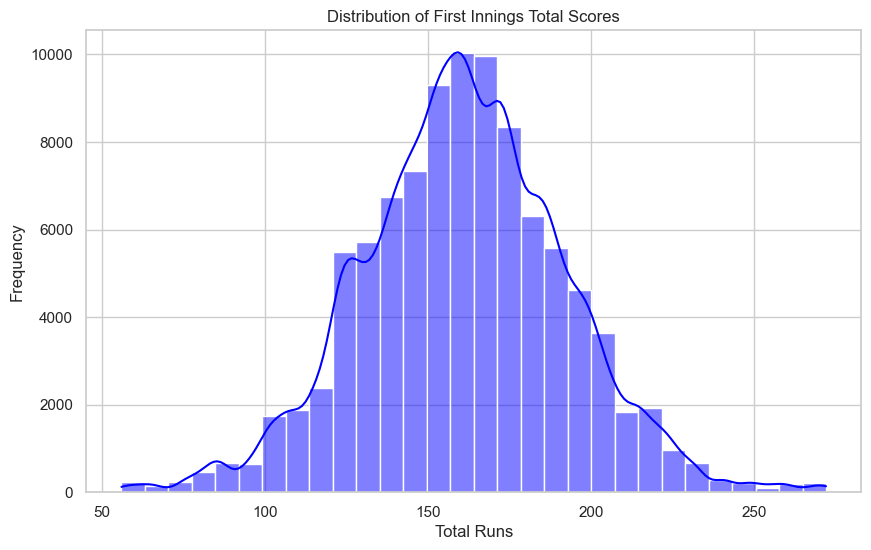

In [97]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_runs_x'], bins=30, kde=True, color='blue')
plt.title('Distribution of First Innings Total Scores')
plt.xlabel('Total Runs')
plt.ylabel('Frequency')
plt.show()

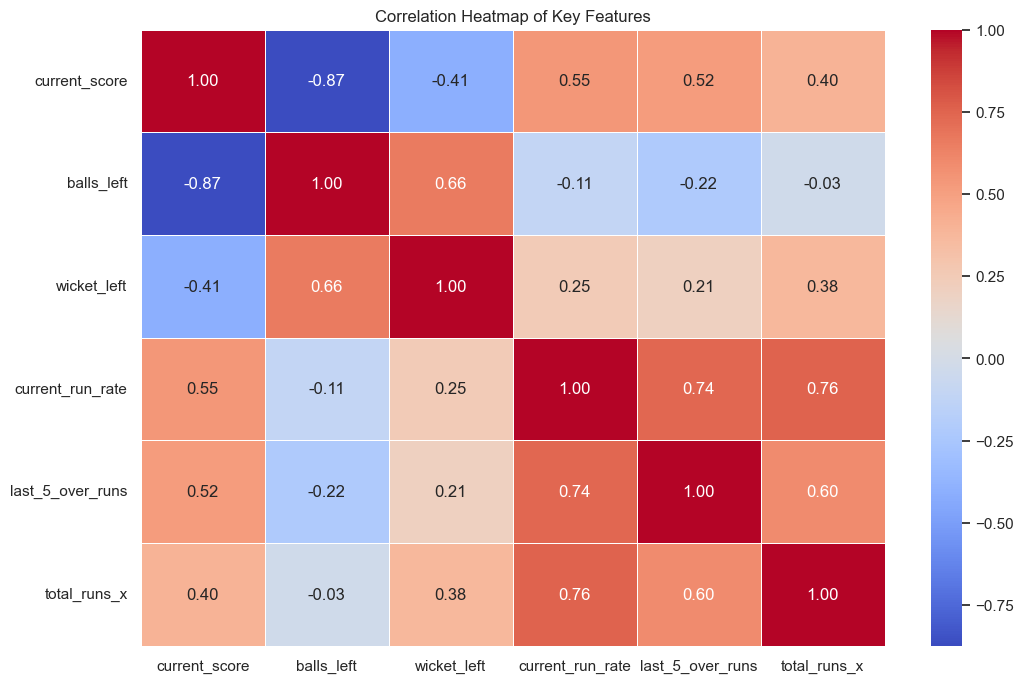

In [98]:

numerical_cols = ['current_score', 'balls_left', 'wicket_left', 
                  'current_run_rate', 'last_5_over_runs', 'total_runs_x']

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Features')
plt.show()

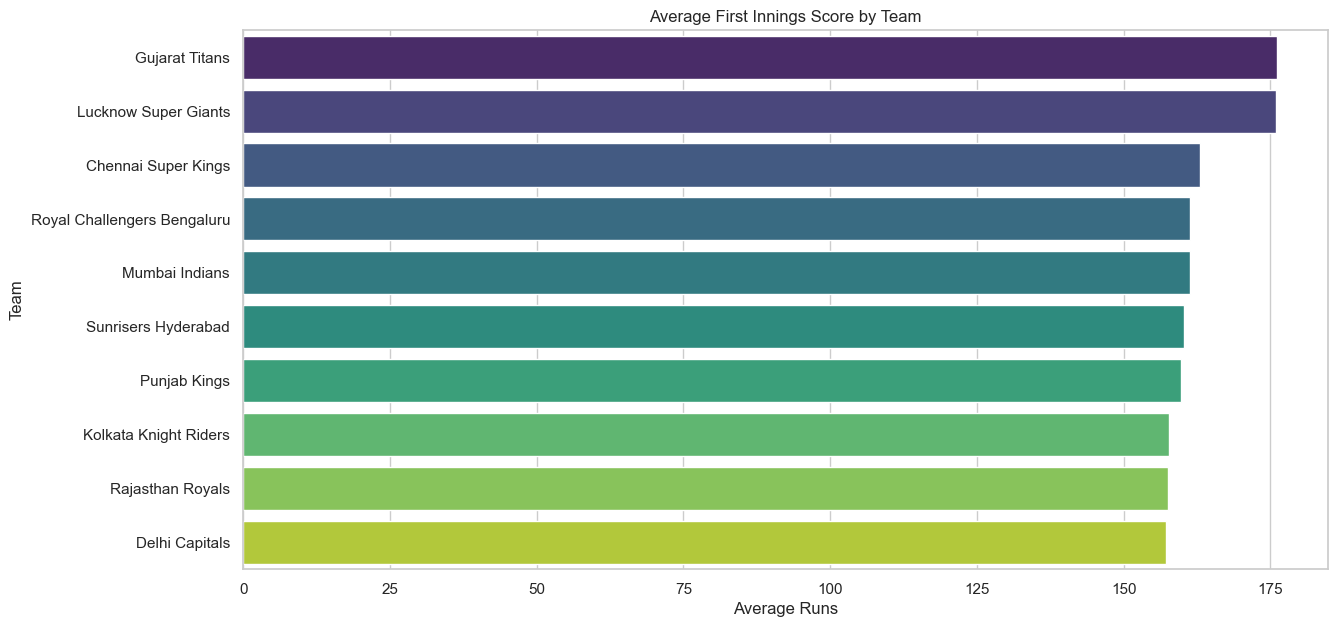

In [99]:
plt.figure(figsize=(14, 7))
avg_runs = df.groupby('batting_team')['total_runs_x'].mean().sort_values(ascending=False)
sns.barplot(x=avg_runs.values, y=avg_runs.index, palette='viridis')
plt.title('Average First Innings Score by Team')
plt.xlabel('Average Runs')
plt.ylabel('Team')
plt.show()

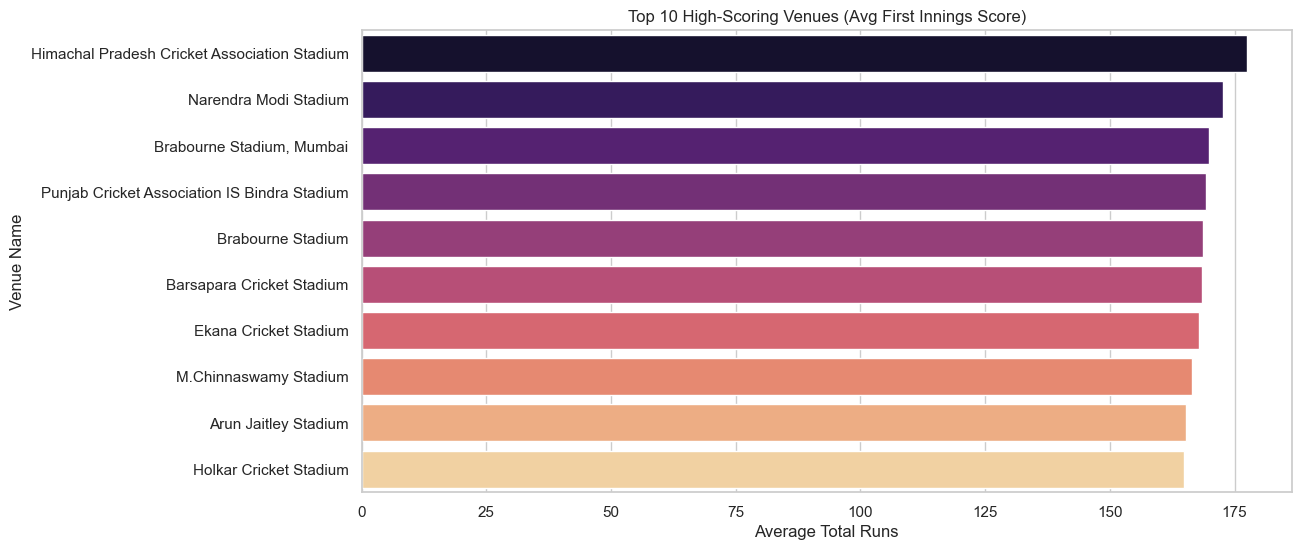

In [100]:
top_venues = df.groupby('venue')['total_runs_x'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_venues.values, y=top_venues.index, palette='magma')
plt.title('Top 10 High-Scoring Venues (Avg First Innings Score)')
plt.xlabel('Average Total Runs')
plt.ylabel('Venue Name')
plt.show()

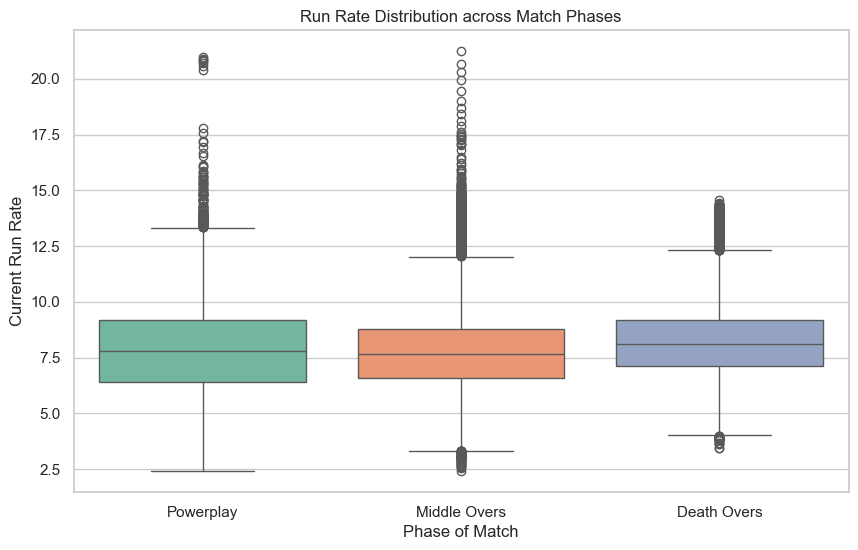

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='match_phase', y='current_run_rate', data=df, palette='Set2')
plt.title('Run Rate Distribution across Match Phases')
plt.xlabel('Phase of Match')
plt.ylabel('Current Run Rate')
plt.show()

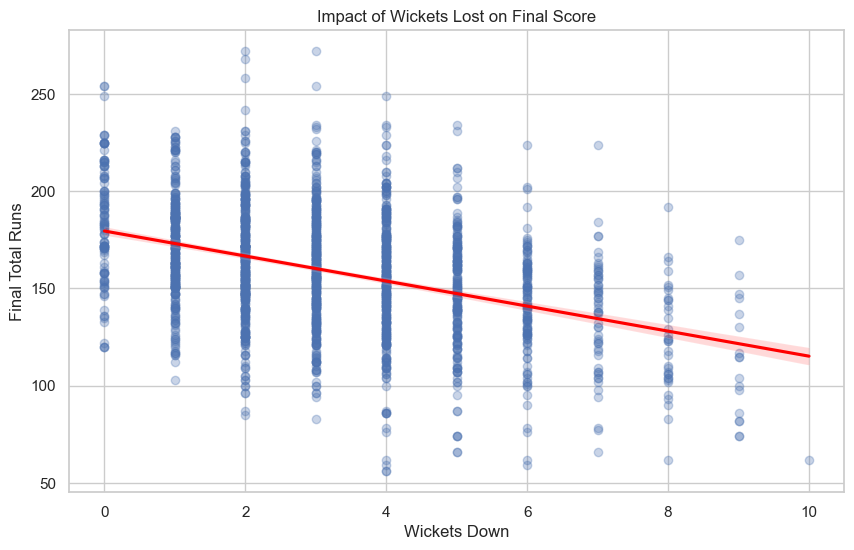

In [102]:
plt.figure(figsize=(10, 6))
sns.regplot(x='wickets_down', y='total_runs_x', data=df.sample(2000), 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Impact of Wickets Lost on Final Score')
plt.xlabel('Wickets Down')
plt.ylabel('Final Total Runs')
plt.show()

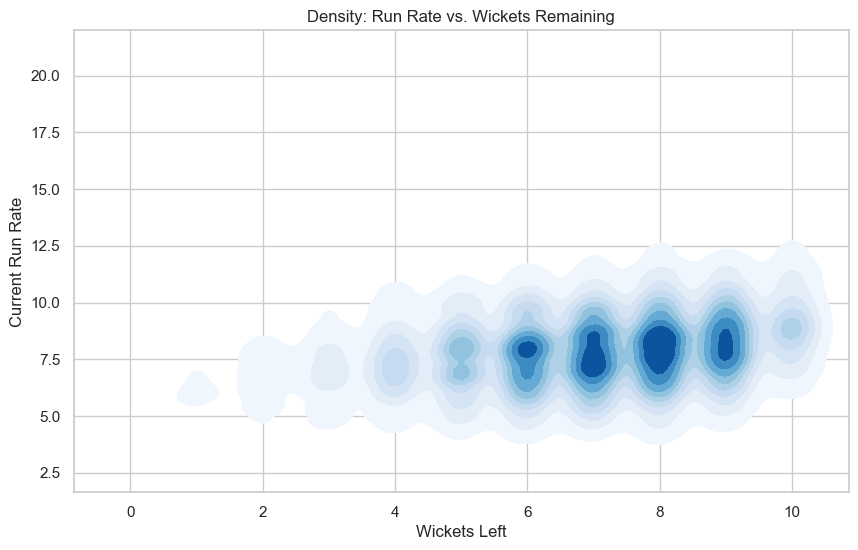

In [103]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='wicket_left', y='current_run_rate', fill=True, cmap='Blues')
plt.title('Density: Run Rate vs. Wickets Remaining')
plt.xlabel('Wickets Left')
plt.ylabel('Current Run Rate')
plt.show()

In [104]:
from sklearn.model_selection import train_test_split

y = df['total_runs_x']

features_cat = [
    'batting_team_avg_last10',
    'bowling_team_avg_conceded_last10',
    'venue_avg_score',
    'balls_left', 
    'wicket_left', 
    'current_run_rate', 
    'last_5_over_runs',
    'last_5_over_wickets',
    'striker_sr',
    'non_striker_sr',
    'finisher_death_impact'
]

X_cat = df[features_cat]

features_xgb = [
    'batting_team_avg_last10',
    'bowling_team_avg_conceded_last10',
    'venue_avg_score',
    'balls_left', 
    'wicket_left', 
    'current_run_rate', 
    'last_5_over_runs',
    'last_5_over_wickets',
    'striker_sr',
    'non_striker_sr',
    'finisher_death_impact',
    'striker_role',     
    'non_striker_role'  
]

X_xgb = df[features_xgb]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y, test_size=0.2, random_state=42
)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42
)

print(f"CatBoost training features: {X_train_cat.shape[1]}") # Should be 11
print(f"XGBoost training features: {X_train_xgb.shape[1]}")  # Should be 13

CatBoost training features: 11
XGBoost training features: 13


In [105]:
import sys
print(sys.version)

3.13.11 (tags/v3.13.11:6278944, Dec  5 2025, 16:26:58) [MSC v.1944 64 bit (AMD64)]


In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from catboost import CatBoostRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

trf_xgb = ColumnTransformer([
    
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [
        'striker_role', 'non_striker_role'  
    ])
], remainder='passthrough')

pipe2 = Pipeline(steps=[
    ('step1', trf_xgb),
    ('step2', StandardScaler(with_mean=False)), 
    ('step3', XGBRegressor(
        n_estimators=1500,           # High number of trees for better learning
        learning_rate=0.03,          # Lower rate for smoother convergence
        max_depth=9,                 # Deeper trees to capture interactions
        subsample=0.8,               # Prevent overfitting by using 80% of data per tree
        colsample_bytree=0.8,        # Use 80% of features per tree
        reg_lambda=10,               # L2 regularization (equivalent to l2_leaf_reg)
        reg_alpha=1,                 # L1 regularization for sparsity
        gamma=0.1,                   # Minimum loss reduction for a split
        n_jobs=-1,                   # Use all CPU cores
        random_state=42,             # Reproducible results
        objective='reg:squarederror' # Standard regression objective
    ))
])
weights_train_xgb = np.where(y_train_xgb > 210, 3.0, 1.0)
mask_mid_xgb = (y_train_xgb > 180) & (y_train_xgb <= 210)
weights_train_xgb[mask_mid_xgb] = 2.0
from sklearn.metrics import r2_score, mean_absolute_error,root_mean_squared_error

pipe2.fit(X_train_xgb, y_train_xgb, step3__sample_weight=weights_train_xgb)

y_pred = pipe2.predict(X_test_xgb)

print("XGBoost R2 Score:", r2_score(y_test_xgb, y_pred))
print("XGBoost MAE:", mean_absolute_error(y_test_xgb, y_pred))
print("XGBoost RMSE:", root_mean_squared_error(y_test_xgb, y_pred))

XGBoost R2 Score: 0.9916452169418335
XGBoost MAE: 1.8721686637105417
XGBoost RMSE: 2.8553121028469732


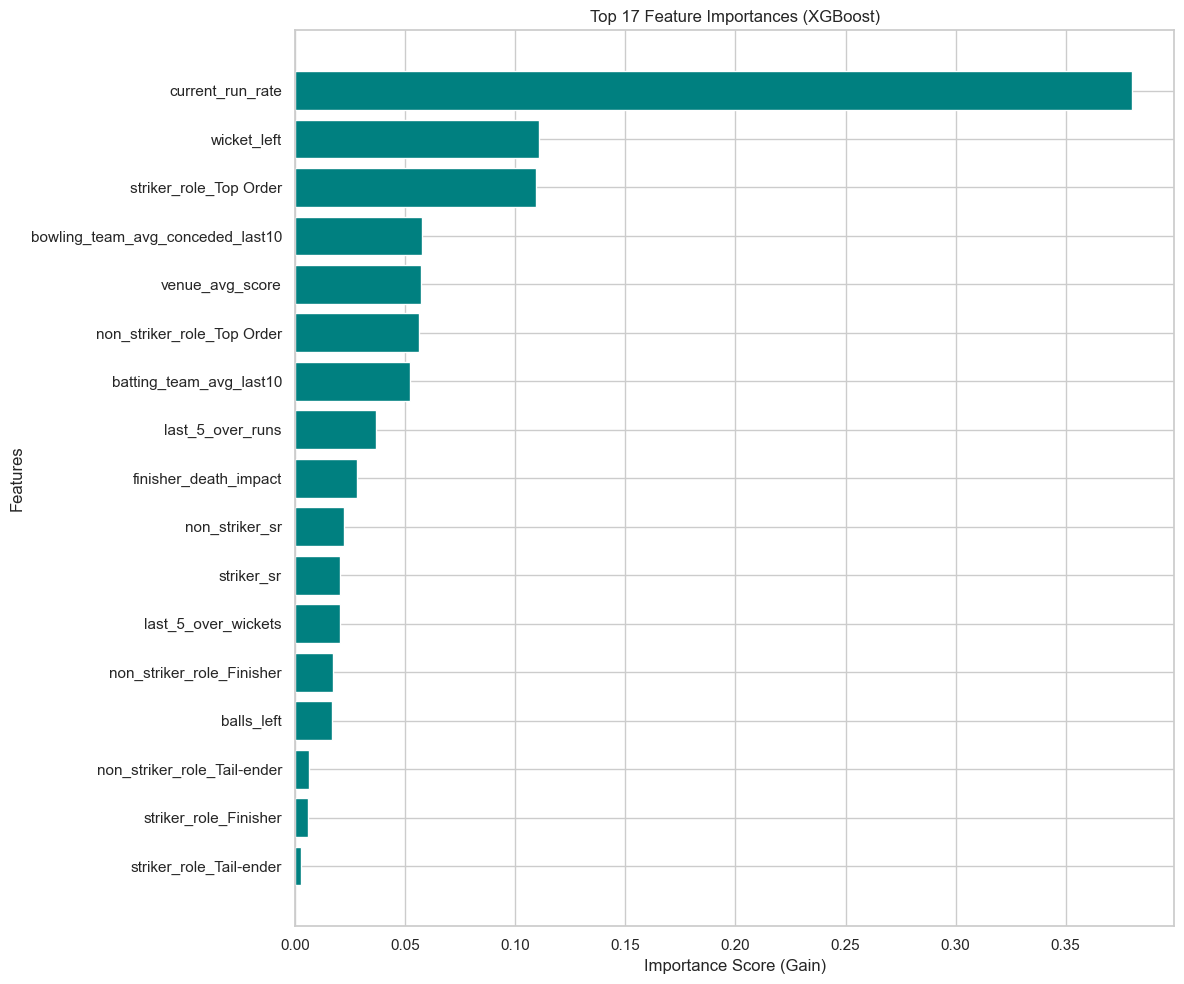

                             Feature  Importance
11                  current_run_rate    0.380172
10                       wicket_left    0.110680
2             striker_role_Top Order    0.109557
7   bowling_team_avg_conceded_last10    0.057454
8                    venue_avg_score    0.056988
5         non_striker_role_Top Order    0.056041
6            batting_team_avg_last10    0.052185
12                  last_5_over_runs    0.036512
16             finisher_death_impact    0.028046
15                    non_striker_sr    0.022395
14                        striker_sr    0.020574
13               last_5_over_wickets    0.020489
3          non_striker_role_Finisher    0.017400
9                         balls_left    0.016803
4        non_striker_role_Tail-ender    0.006237
0              striker_role_Finisher    0.005792
1            striker_role_Tail-ender    0.002674


In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Extract transformer and model from pipe2
transformer = pipe2.named_steps['step1']
model = pipe2.named_steps['step3']

# 2. Get One-Hot Encoded feature names
categorical_cols = ['striker_role', 'non_striker_role']
try:
    ohe_feature_names = list(transformer.named_transformers_['encoder'].get_feature_names_out(categorical_cols))
except (AttributeError, ValueError, KeyError):
    ohe_feature_names = []

# 3. Identify remaining features (numerical ones)
numerical_features = [f for f in features_xgb if f not in categorical_cols]

# 4. Combine names in the correct order (OHE names + Passthrough names)
all_feature_names = ohe_feature_names + numerical_features

# 5. Extract importance scores
importances = model.feature_importances_

if len(all_feature_names) == len(importances):
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 6. Plotting
    plt.figure(figsize=(12, 10))
    top_n = min(len(feature_importance_df), 20)
    
    plt.barh(feature_importance_df['Feature'][:top_n], 
             feature_importance_df['Importance'][:top_n], 
             color='teal')

    plt.xlabel('Importance Score (Gain)')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} Feature Importances (XGBoost)')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png')
    plt.show()

    print(feature_importance_df.head(top_n))
else:
    print(f"Error: Feature names ({len(all_feature_names)}) don't match importances ({len(importances)})")

In [ ]:
trf_cat = ColumnTransformer([
    ('scaler', StandardScaler(), features_cat)
], remainder='passthrough')



pipe1 = Pipeline(steps=[
    ('step1', trf_cat),
    ('step2', StandardScaler(with_mean=False)), 
    ('step3',CatBoostRegressor(
    iterations=1500,           # Increase from 800 to allow deeper learning
    learning_rate=0.03,        # Slightly lower for more precise optimization
    depth=8,                  # Increase from 6 to capture more complex patterns
    l2_leaf_reg=10,             # Regularization to prevent overfitting
    bagging_temperature=0.2,   # Adds randomness to improve generalization
    random_strength=1,         # Helps prevent overfitting on specific scores
    loss_function='RMSE',      # Standard for regression
    random_seed=42,            # Ensures results are reproducible
    verbose=100                # Keeps the output clean
))  
]) 

weights_train_cat = np.where(y_train_cat > 210, 3.0, 1.0)
mask_mid_cat = (y_train_cat > 180) & (y_train_cat <= 210)
weights_train_cat[mask_mid_cat] = 2.0


from sklearn.metrics import r2_score, mean_absolute_error
pipe1.fit(X_train_cat, y_train_cat, step3__sample_weight=weights_train_cat)
y_pred = pipe1.predict(X_test_cat)
print(r2_score(y_test_cat,y_pred))
print(mean_absolute_error(y_test_cat,y_pred))
  

0:	learn: 33.8688086	total: 122ms	remaining: 3m 2s
100:	learn: 17.9108627	total: 1s	remaining: 13.9s
200:	learn: 16.1722621	total: 1.81s	remaining: 11.7s
300:	learn: 14.9065978	total: 2.62s	remaining: 10.4s
400:	learn: 13.8339572	total: 3.44s	remaining: 9.42s
500:	learn: 12.8761528	total: 4.25s	remaining: 8.48s
600:	learn: 12.0724175	total: 5.1s	remaining: 7.63s
700:	learn: 11.4007680	total: 5.92s	remaining: 6.75s
800:	learn: 10.7718978	total: 6.74s	remaining: 5.88s
900:	learn: 10.2316222	total: 7.56s	remaining: 5.03s
1000:	learn: 9.7364409	total: 8.38s	remaining: 4.18s
1100:	learn: 9.2700147	total: 9.2s	remaining: 3.33s
1200:	learn: 8.8620428	total: 10s	remaining: 2.5s
1300:	learn: 8.4651104	total: 10.8s	remaining: 1.66s
1400:	learn: 8.1150248	total: 11.6s	remaining: 823ms
1499:	learn: 7.8043034	total: 12.4s	remaining: 0us
0.9272047330106148
6.277478122315417


In [112]:
print(root_mean_squared_error(y_test_cat,y_pred))

8.428265238824087


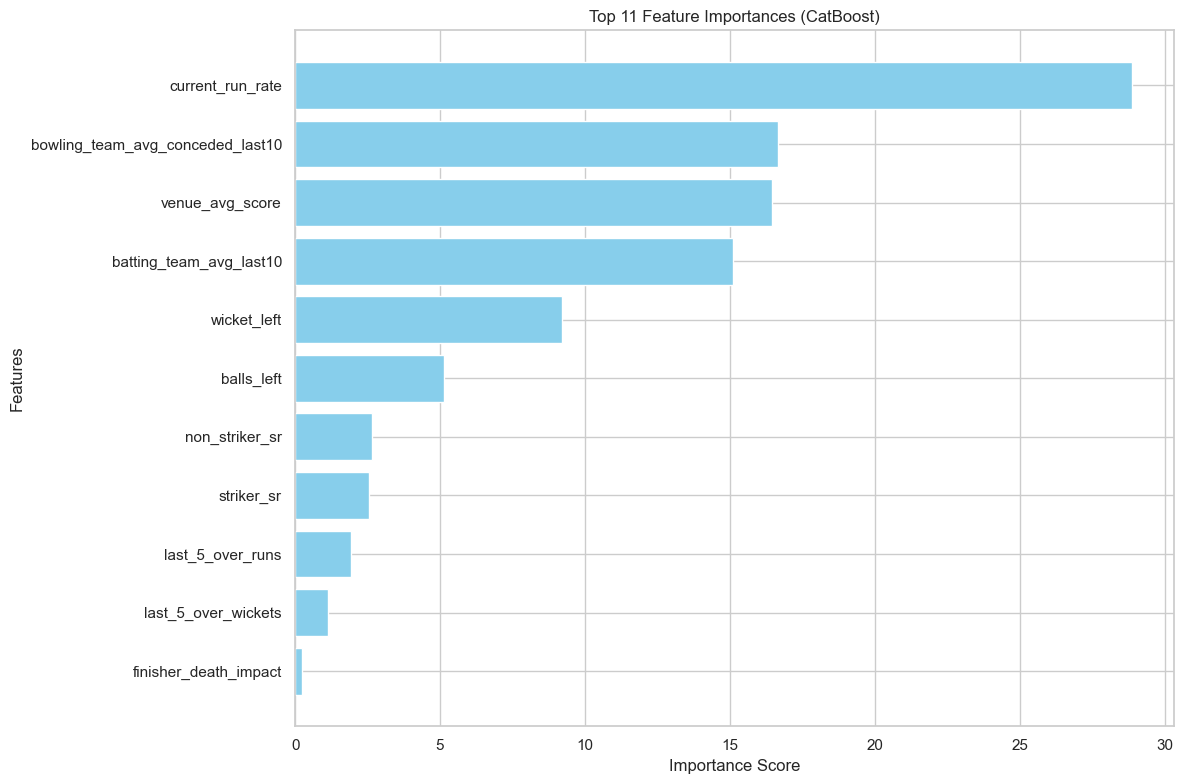

                             Feature  Importance
5                   current_run_rate   28.878228
1   bowling_team_avg_conceded_last10   16.671903
2                    venue_avg_score   16.442087
0            batting_team_avg_last10   15.115607
4                        wicket_left    9.191114
3                         balls_left    5.149867
9                     non_striker_sr    2.663490
8                         striker_sr    2.545140
6                   last_5_over_runs    1.941737
7                last_5_over_wickets    1.146504
10             finisher_death_impact    0.254322


In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

transformer = pipe1.named_steps['step1']
model = pipe1.named_steps['step3']

categorical_cols = ['batting_team', 'bowling_team', 'venue']

try:
    ohe_feature_names = list(transformer.named_transformers_['encoder'].get_feature_names_out())
except (AttributeError, ValueError, KeyError):
    ohe_feature_names = []

passthrough_features = [f for f in features_cat if f not in categorical_cols]

all_feature_names = ohe_feature_names + passthrough_features


importances = model.feature_importances_

# 4. Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Plotting
plt.figure(figsize=(12, 8))

# Dynamically set top_n based on available features (max 20)
top_n = min(len(feature_importance_df), 20)

plt.barh(feature_importance_df['Feature'][:top_n], 
         feature_importance_df['Importance'][:top_n], 
         color='skyblue')

plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importances (CatBoost)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()

# Save and Show
plt.savefig('catboost_feature_importance.png')
plt.show()

# Display the numerical values
print(feature_importance_df.head(top_n))

In [118]:
import sklearn
print(sklearn.__version__)


1.5.2


--- Linear Regression (Remaining Runs) Accuracy ---
R2 Score: 0.8008
Mean Absolute Error (MAE): 14.11 runs
the root mean squared error is : 18.74 runs


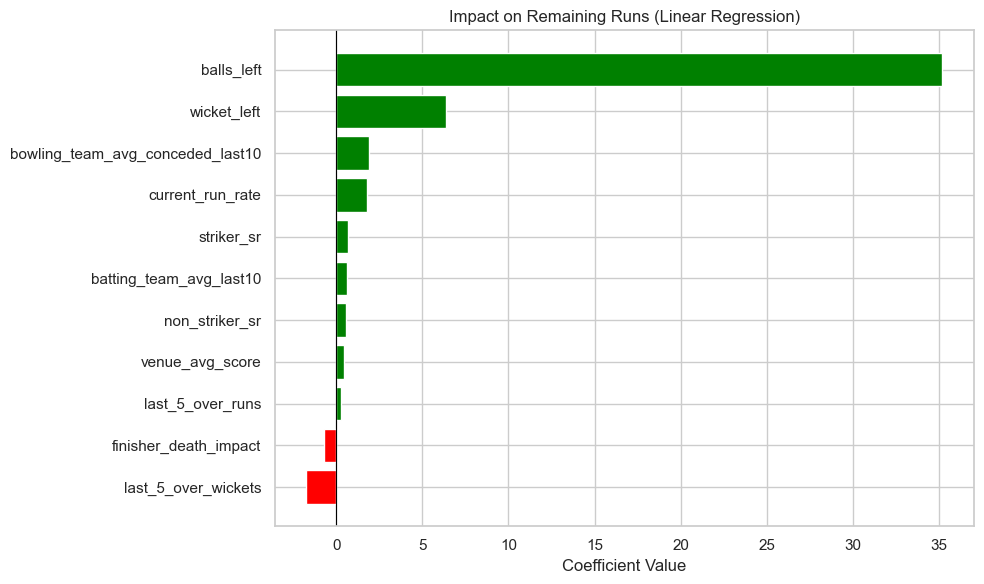


Linear Regression trained and evaluated successfully!


In [117]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

df['remaining_runs'] = df['total_runs_x'] - df['current_score']

features_lr = [
    'batting_team_avg_last10', 'bowling_team_avg_conceded_last10', 'venue_avg_score',
    'balls_left', 'wicket_left', 'current_run_rate', 'last_5_over_runs', 
    'last_5_over_wickets', 'striker_sr', 'non_striker_sr', 'finisher_death_impact'
]

X_lr = df[features_lr]
y_lr = df['remaining_runs']      # Target for prediction
y_final = df['total_runs_x']     # Used for calculating sample weights

X_train_lr, X_test_lr, y_train_rem, y_test_rem, y_train_actual, y_test_actual = train_test_split(
    X_lr, y_lr, y_final, test_size=0.2, random_state=42
)

weights_lr = np.where(y_train_actual > 200, 3, 1.0)
weights_lr[(y_train_actual > 180) & (y_train_actual <= 200)] = 2

trf_lr = ColumnTransformer([
    ('scaler', StandardScaler(with_mean=False), features_lr)
], remainder='passthrough')

pipe3 = Pipeline(steps=[
    ('step1', trf_lr),
    ('step2', LinearRegression())
])

pipe3.fit(X_train_lr, y_train_rem, step2__sample_weight=weights_lr)

y_pred = pipe3.predict(X_test_lr)

print("--- Linear Regression (Remaining Runs) Accuracy ---")
print(f"R2 Score: {r2_score(y_test_rem, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_rem, y_pred):.2f} runs")
print(f"the root mean squared error is : {root_mean_squared_error(y_test_rem, y_pred):.2f} runs")

import matplotlib.pyplot as plt

model_lr = pipe3.named_steps['step2']
importance_df = pd.DataFrame({
    'Feature': features_lr, 
    'Importance': model_lr.coef_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in importance_df['Importance']]
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.title('Impact on Remaining Runs (Linear Regression)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nLinear Regression trained and evaluated successfully!")

In [116]:
import pickle

pickle.dump(pipe3, open('pipe3.pkl', 'wb'))

In [119]:
import pandas as pd
import numpy as np
import pickle
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

features_xgb = [
    'batting_team_avg_last10', 'bowling_team_avg_conceded_last10', 'venue_avg_score',
    'balls_left', 'wicket_left', 'current_run_rate', 'last_5_over_runs', 
    'last_5_over_wickets', 'striker_sr', 'non_striker_sr', 
    'finisher_death_impact', 'striker_role', 'non_striker_role'
]

# 2. Data Preparation
X = df[features_xgb]
y = df['total_runs_x']

# Split the data
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

weights_xgb = np.where(y_train_xgb > 200, 3, 1.0)
weights_xgb[(y_train_xgb > 180) & (y_train_xgb <= 200)] = 2

trf_lgb = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
     ['striker_role', 'non_striker_role'])
], remainder='passthrough')

pipe4 = Pipeline(steps=[
    ('step1', trf_lgb),
    ('step2', StandardScaler(with_mean=False)),
    ('step3', LGBMRegressor(
        n_estimators=2000,        # More trees for finer detail
        learning_rate=0.015,      # Smaller steps for higher accuracy
        num_leaves=64,            # Complexity of individual trees
        max_depth=12,             # Limits tree depth to prevent over-specialization
        min_child_samples=20,     # Minimum data points in a leaf (prevents overfitting)
        reg_alpha=0.1,            # L1 regularization (removes noise)
        reg_lambda=0.1,           # L2 regularization (smooths weights)
        subsample=0.8,            # Use 80% of data for each tree (Bagging)
        colsample_bytree=0.8,     # Use 80% of features for each tree
        random_state=42,
        importance_type='gain',
        n_jobs=-1  # Measures feature contribution to the model
    ))
])

pipe4.fit(X_train_xgb, y_train_xgb, step3__sample_weight=weights_xgb)

y_pred_lgb = pipe4.predict(X_test_xgb)

lgb_r2 = r2_score(y_test_xgb, y_pred_lgb)
lgb_mae = mean_absolute_error(y_test_xgb, y_pred_lgb)

print("--- LightGBM Model Performance ---")
print(f"R2 Score: {lgb_r2:.4f}")
print(f"Mean Absolute Error (MAE): {lgb_mae:.2f} runs")
print(f"the root mean squared error is : {root_mean_squared_error(y_test_xgb, y_pred_lgb):.2f} runs")
pickle.dump(pipe4, open('pipe4.pkl', 'wb'))
print("\nModel saved as pipe4.pkl")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1746
[LightGBM] [Info] Number of data points in the train set: 78248, number of used features: 17
[LightGBM] [Info] Start training from score 172.321718
--- LightGBM Model Performance ---
R2 Score: 0.9694
Mean Absolute Error (MAE): 4.07 runs
the root mean squared error is : 5.46 runs

Model saved as pipe4.pkl


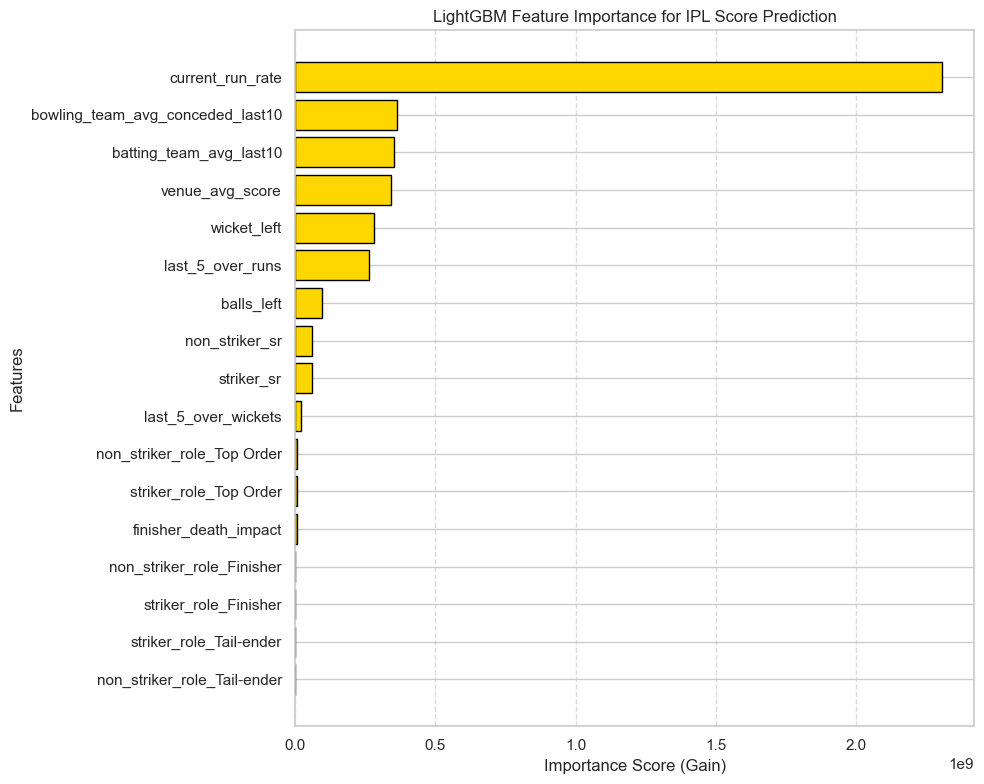

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_names = pipe4.named_steps['step1'].get_feature_names_out()

clean_feature_names = [name.split('__')[-1] for name in feature_names]

importances = pipe4.named_steps['step3'].feature_importances_

feature_imp_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True) # Ascending=True for a better horizontal plot

plt.figure(figsize=(10, 8))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color='gold', edgecolor='black')

plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance for IPL Score Prediction')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [121]:
from sklearn.ensemble import RandomForestRegressor
import pickle

pipe5 = Pipeline(steps=[
    ('step1', trf_lgb),  # Uses your existing transformer with OneHotEncoding
    ('step2', StandardScaler(with_mean=False)),
    ('step3', RandomForestRegressor(
        n_estimators=500,      # Number of trees
        max_depth=15,          # Prevents trees from becoming too complex
        min_samples_leaf=5,     # Ensures each leaf has a minimum number of matches
        max_features='sqrt',   # Randomly selects features for better diversity
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Fit the model 
pipe5.fit(X_train_xgb, y_train_xgb, step3__sample_weight=weights_xgb)

# 3. Save the model
pickle.dump(pipe5, open('pipe5.pkl', 'wb'))

print("Random Forest Model Trained and Saved as pipe5.pkl")
y_pred_rf = pipe5.predict(X_test_xgb)

# 2. Calculate Metrics
rf_r2 = r2_score(y_test_xgb, y_pred_rf)
rf_mae = mean_absolute_error(y_test_xgb, y_pred_rf)

print("--- Random Forest Performance Metrics ---")
print(f"R2 Score: {rf_r2:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f} runs")
print(f"the root mean squared error is : {root_mean_squared_error(y_test_xgb, y_pred_rf):.2f} runs")

Random Forest Model Trained and Saved as pipe5.pkl
--- Random Forest Performance Metrics ---
R2 Score: 0.8865
Mean Absolute Error (MAE): 7.56 runs
the root mean squared error is : 10.52 runs


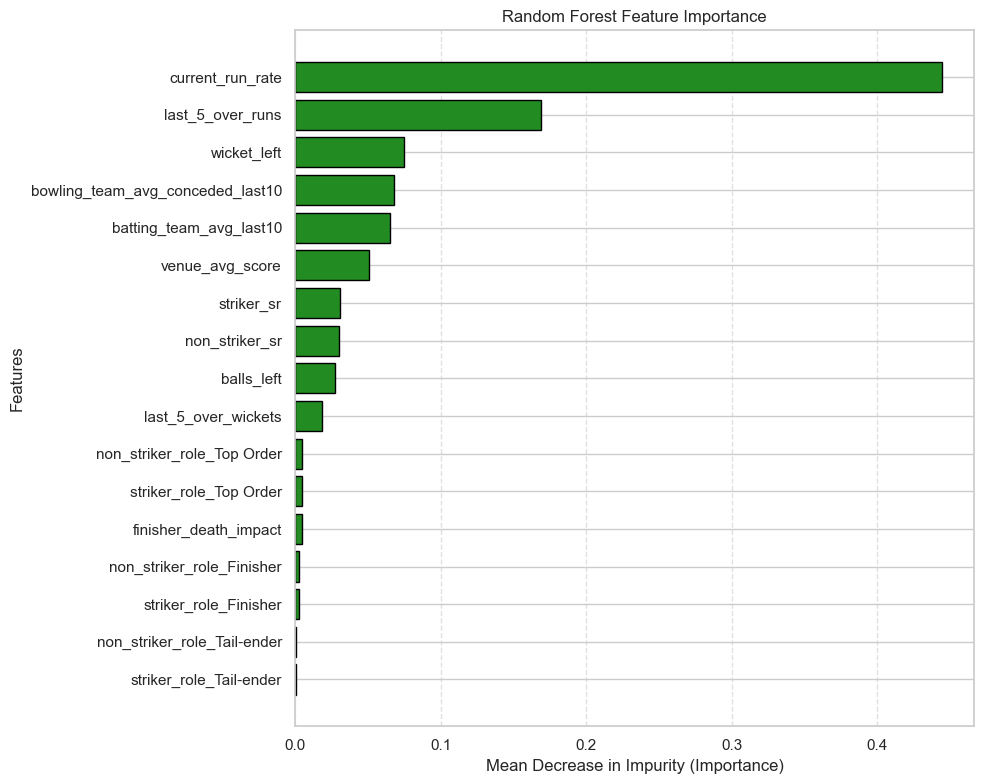

In [122]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = pipe5.named_steps['step1'].get_feature_names_out()

clean_feature_names = [name.split('__')[-1] for name in feature_names]

importances = pipe5.named_steps['step3'].feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='forestgreen', edgecolor='black')

plt.xlabel('Mean Decrease in Impurity (Importance)')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [123]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

pipe6 = Pipeline(steps=[
    ('step1', trf_lr), # Your existing 11-feature transformer
    ('step2', StandardScaler(with_mean=False)),
    ('step3', SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale'))
])

pipe6.fit(X_train_lr, y_train_rem)

y_pred_svr = pipe6.predict(X_test_lr)

svr_r2 = r2_score(y_test_rem, y_pred_svr)
svr_mae = mean_absolute_error(y_test_rem, y_pred_svr)

print("--- Support Vector Regression (SVR) Performance ---")
print(f"R2 Score: {svr_r2:.4f}")
print(f"Mean Absolute Error (MAE): {svr_mae:.2f} runs")
print(f"the root mean squared error is : {root_mean_squared_error(y_test_rem, y_pred_svr):.2f} runs")

pickle.dump(pipe6, open('pipe6.pkl', 'wb'))

--- Support Vector Regression (SVR) Performance ---
R2 Score: 0.8138
Mean Absolute Error (MAE): 13.47 runs
the root mean squared error is : 18.12 runs


In [124]:
pickle.dump(pipe6, open('pipe6.pkl', 'wb'))

In [125]:
# 1. Export Batting Stats Lookup
bat_stats_lookup = df.groupby('batting_team').apply(
    lambda x: {'overall': x['batting_team_avg_overall'].iloc[-1], 
               'last10': x['batting_team_avg_last10'].iloc[-1]}
).to_dict()
pickle.dump(bat_stats_lookup, open('batting_stats.pkl', 'wb'))

# 2. Export Bowling Stats Lookup
bowl_stats_lookup = df.groupby('bowling_team').apply(
    lambda x: {'overall': x['bowling_team_avg_conceded_overall'].iloc[-1], 
               'last10': x['bowling_team_avg_conceded_last10'].iloc[-1]}
).to_dict()
pickle.dump(bowl_stats_lookup, open('bowling_stats.pkl', 'wb'))

In [ ]:
import pickle
import pandas as pd

# 1. Save the trained pipeline
pickle.dump(pipe1, open('pipe1.pkl', 'wb'))


pickle.dump(pipe2,open('pipe2.pkl','wb'))
# 3. Save Player Lookup (Player -> Role)
# We take the most frequent role assigned to each player in your dataset
player_lookup = df.groupby('batter')['striker_role'].last().to_dict()
pickle.dump(player_lookup, open('player_lookup.pkl', 'wb'))
pickle.dump(sr_map, open('sr_lookup.pkl', 'wb')) # NEW
# 4. Save list of teams for the dropdown
teams = sorted(df['batting_team'].unique().tolist())
pickle.dump(teams, open('teams.pkl', 'wb'))


    
print("All files exported successfully!")

All files exported successfully!
